# <center>Sales Prediction using ARIMA and SARIMA</center>

* ARIMA - Auto-Regressive Integrated Moving Average
* SARIMA - Seasonal Autoregressive Integrated Moving Average
* SARIMAX - Seasonal Autoregressive Integrated Moving Average with Exogenous Variables

## Dataset and Objective:

```Objective:```
* Use time series concepts to forecast champagne sales
* The dataset is monthly sales of champagne from year 1964 to 1972

The data contains 2 columns:

- **month:** contains the month data
- **Perrin Freres monthly champagne sales millions:** contains the monthly champagne sales values in millions


## Steps to achieve the objective:

0. Importing Necessary Libraries
1. Loading and Preprocessing of Dataset (Time series data)
2. Visualize the Time Series Data
3. Check the stationarity of time series data
4. If not stationary  -- > Make the time series data stationary
5. Plot the Correlation and AutoCorrelation Charts
6. Construct the ARIMA Model or Seasonal ARIMA based on the data
7. Use the model to make predictions
8. Pros and Cons of ARIMA & SARIMA

Let's go through these steps!

## Importing Necessary Libraries:

In [1]:
# Importing libraries:

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Loading and Pre-processing Dataset:

In [2]:
# Reading sales data

data = pd.read_csv("champagne_sales_data.csv")

In [3]:
# Take a glance of dataset:
data.sample(3)

,Month,Perrin Freres monthly champagne sales millions ?64-?72
18,1965-07,3028.0
56,1968-09,5048.0
6,1964-07,2282.0


In [4]:
# Renaming the column name with a insighful name:

data.columns = ['Month', 'Sales']
data.head(3)

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0


In [5]:
# check shape of dataset:

print(f"Shape of the dataset is: {data.shape}")

Shape of the dataset is: (107, 2)


In [6]:
# Check for NULL Rows:

data.isna().sum()

Month    1
Sales    2
dtype: int64

In [7]:
data.tail(4)

,Month,Sales
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


'Month' column has 1 NULL row and 'Sales' column has 2 NULL rows.

In [8]:
# Drop rows contains NULL value for 'sales' or 'Month':

# Drop row with index - 106
data.drop(106, axis=0, inplace=True)

# Drop row woth index - 105
data.drop(105, axis=0, inplace=True)

# Now check the shape:
print(f"After cleaning, Shape of dataset is: {data.shape}")

After cleaning, Shape of dataset is: (105, 2)


In [9]:
# Checking dtype of dataset:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   105 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB
None


We need to ```convert the 'Month' column ```dtype to ```datetime object```

In [10]:
# Converting "month" column to "datetime" type using "pandas" library:

data['Month'] = pd.to_datetime(data['Month'])

In [11]:
# Now, check the dtype of columns:
data.dtypes

Month    datetime64[ns]
Sales           float64
dtype: object

In [12]:
# Now see the dataset:
data.head(4)

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0


Now, ```Set "Month" column as index:```

In [13]:
data.set_index('Month', inplace=True)

In [14]:
# see prepared dataset:

print(f"Dataset after preprocessing: \n")
data.head(4)

Dataset after preprocessing: 



,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0


Descriptive Statistics -- view of 'Sales'column:

In [15]:
# Descriptive statistics:

data.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


## 2. Plotting Data

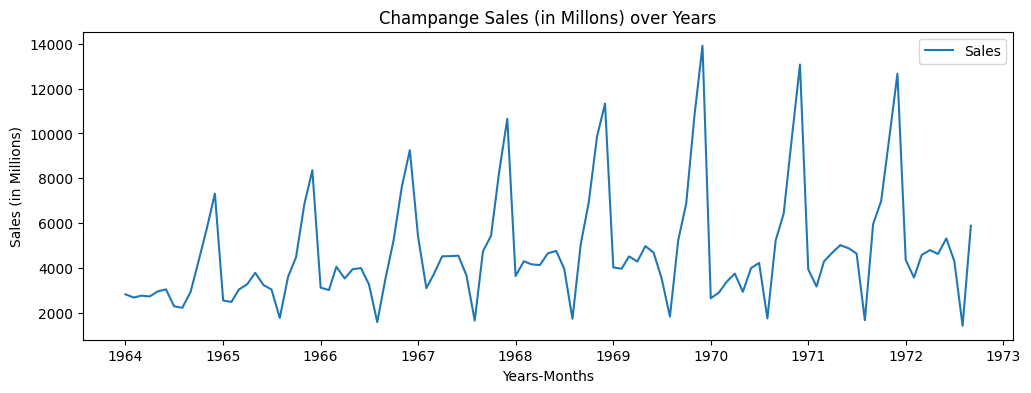

In [16]:
plt.figure(figsize= (12,4))
plt.plot(data['Sales'], label = "Sales")
plt.legend()
plt.title('Champange Sales (in Millons) over Years')
plt.xlabel("Years-Months")
plt.ylabel("Sales (in Millions)")
plt.show();

### Plotting for 2 or 3 years monthly sales -- to check seasonality:

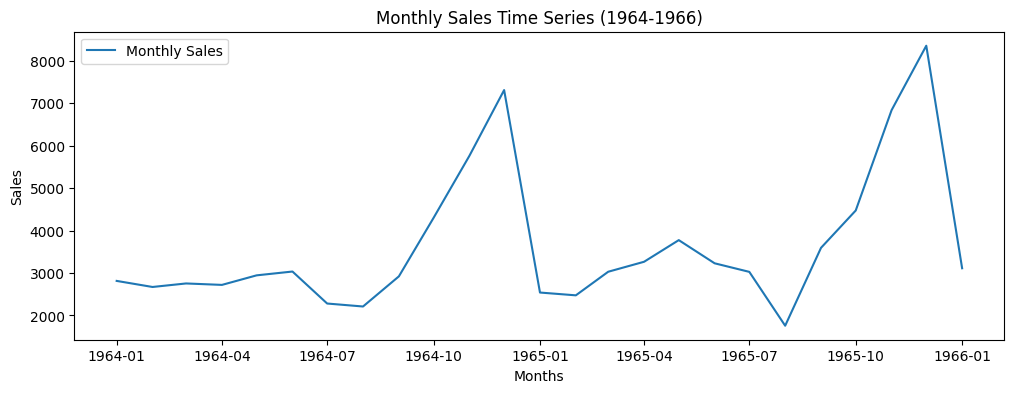

In [17]:
# Selecting data for the desired date range (e.g., 1964 to 1965)
start_date = '1964-01-01'
end_date = '1966-01-01'
subset = data[start_date:end_date]

# Plotting the time series
plt.figure(figsize=(12, 4))
plt.plot(subset['Sales'], label='Monthly Sales')
plt.title('Monthly Sales Time Series (1964-1966)')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend()
plt.show()

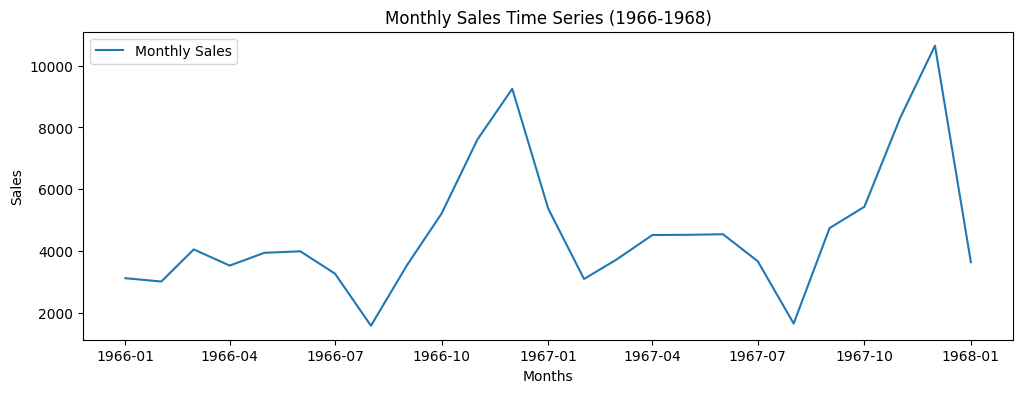

In [18]:
# Selecting data for the desired date range (e.g., 1964 to 1965)
start_date = '1966-01-01'
end_date = '1968-01-01'
subset = data[start_date:end_date]

# Plotting the time series
plt.figure(figsize=(12, 4))
plt.plot(subset['Sales'], label='Monthly Sales')
plt.title('Monthly Sales Time Series (1966-1968)')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend()
plt.show()

```BY looking on above plotting -- we can easily say that the sales has "seasonal pattern".```

```"Seasonal" is all about suppose in each yr in last December (christmas) sales goes up and then down.```

### Chceking Signal Decomposition:

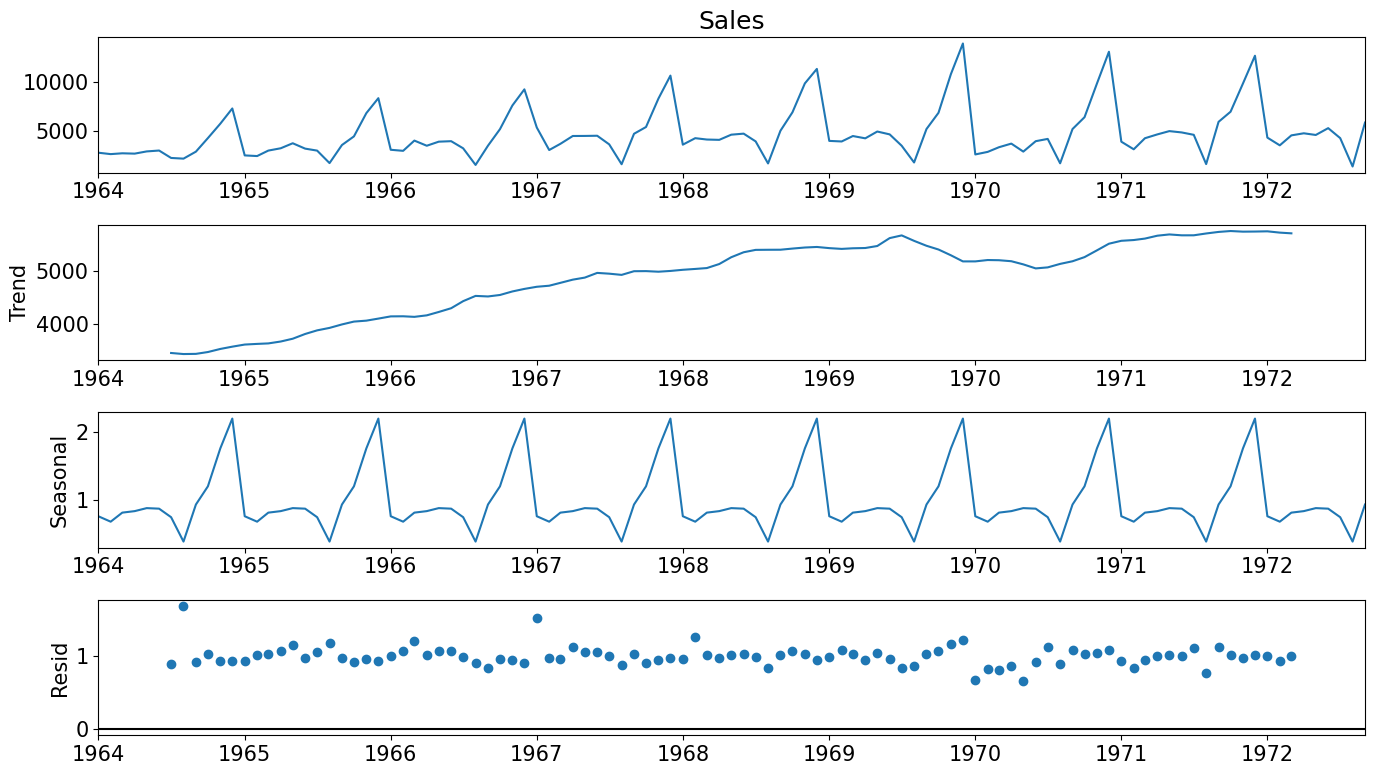

In [19]:
# plot all the components after decomposition:

plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(data['Sales'],model='multiplicative')
fig = result.plot()

```From above plot -- a 12 months seasonal pattern is visible```

## 3. Stationarity Checking:

```A stationary time series is one whose statistical properties, such as mean and variance, remain constant over time.```

```Non-stationary time series may exhibit trends or seasonality, making it challenging to model and forecast accurately.```

**Here are two popular methods for checking stationarity and their key points:**

1. **Visual Incpection:**
    
        Visual Incpection can provide an overview by plotting the time-series data and visually inspectc for trends or seasonality.

2. **Statistical Test:**

There are 2 statistical tests to check whether the time series is stationary or not?:
* **ADF - Augmented Dickey-Fuller Test**
* **Detrending/Differencing**

    

```I have conducted Augmented Dickey-Fuller test to check if our data is stationary or not.```

**Process to conduct the ADF Test**:

- **Method:** A statistical hypothesis test that assesses the presence of a unit root in a univariate time series, indicating non-stationarity.

- **Preferred condition**:
    1. Rigorous statistical test for stationarity.
    2. Suitable for identifying both trend and seasonality in the data.
    
- **Considerations:**
    1. **Null hypothesis (H0):** The time series has a unit root and is non-stationary.
    2. **Alternate hypothesis (H1):** The time series does not have a unit root and is stationary.

    ```A low p-value (typically below a significance level like 0.05) indicates rejection of the null hypothesis, suggesting stationarity.```

```The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a [unit root](https://en.wikipedia.org/wiki/Unit_root) at some level of confidence.```

In [20]:
# from statsmodels.tsa.stattools import adfuller

In [21]:
# Defining a function to check the stationarity:

def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

* adfuller gives 5 values: ```['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used', 'critical_value']```
* Here, the ```most important is p-value```.


In [22]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [23]:
# Use above designed function:

adfuller_test(data['Sales'])

ADF Test Statistic : -1.8335930563276195
p-value : 0.3639157716602467
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [24]:
# check stationarity:
check_stationarity(data['Sales'])

The series is NOT stationary


```As p-value is greater than 0.05 --> So, my data is Non-Stationary --> I need to make it stationary.```

## 4. Making Time Series Data --> Stationary:

### Apply Differencing Techniques:

In [25]:
#  at first see dataset:

data

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


In [26]:
# Now shift the data by 1 time unit:

data['Sales'].shift(1)

Month
1964-01-01       NaN
1964-02-01    2815.0
1964-03-01    2672.0
1964-04-01    2755.0
1964-05-01    2721.0
               ...  
1972-05-01    4788.0
1972-06-01    4618.0
1972-07-01    5312.0
1972-08-01    4298.0
1972-09-01    1413.0
Name: Sales, Length: 105, dtype: float64

In [27]:
# adding one new column --> by taking the difference:

data['Sales_first_difference'] = data['Sales'] - data['Sales'].shift(1)

In [28]:
# Taken shift(12) --> because of --  basically year has 12 month cycle -- based on seasonal information

data['Seasonal_first_difference'] = data['Sales'] - data['Sales'].shift(12)

In [29]:
# view first 20 rows -- since 12 rows will have "NaN" value

data.head(20)

,Sales,Sales_first_difference,Seasonal_first_difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


**Now, Check ADF-Test again on new shifted sales information:**

In [30]:
## Again test dickey fuller test

check_stationarity(data['Seasonal_first_difference'].dropna())

The series is stationary


In [31]:
## Again test dickey fuller test
adfuller_test(data['Seasonal_first_difference'].dropna())

ADF Test Statistic : -7.626619157213166
p-value : 2.0605796968136632e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


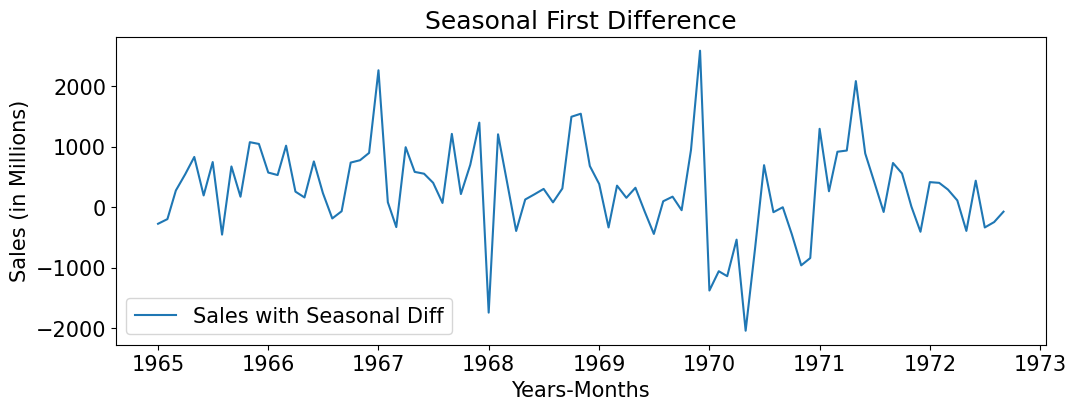

In [32]:
plt.figure(figsize= (12,4))
plt.plot(data['Seasonal_first_difference'], label = "Sales with Seasonal Diff")
plt.legend()
plt.title('Seasonal First Difference')
plt.xlabel("Years-Months")
plt.ylabel("Sales (in Millions)")
plt.show();

## 5. Plot ACF and PACF

```Let’s look at ACF and PACF plots to get an idea for p and q values```

In [33]:
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

### ACF & PACF -- for actual Sales data

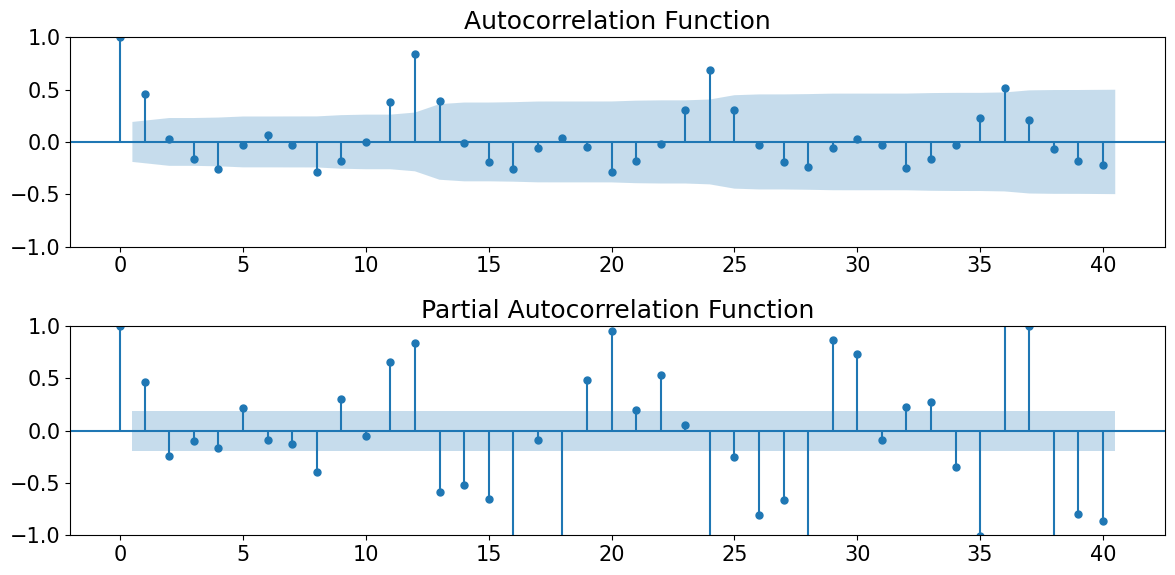

In [34]:
# plot ACF and PACF on initial given sales values:
# Create a 2x1 subplot grid
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6))

# Plot Autocorrelation Function (ACF)
plot_acf(data['Sales'], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function')

# Plot Partial Autocorrelation Function (PACF)
plot_pacf(data['Sales'], lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

# Adjust layout for better readability
plt.tight_layout()

# Show the plots
plt.show()

### ACF & PACF - for Seasonal_first_difference

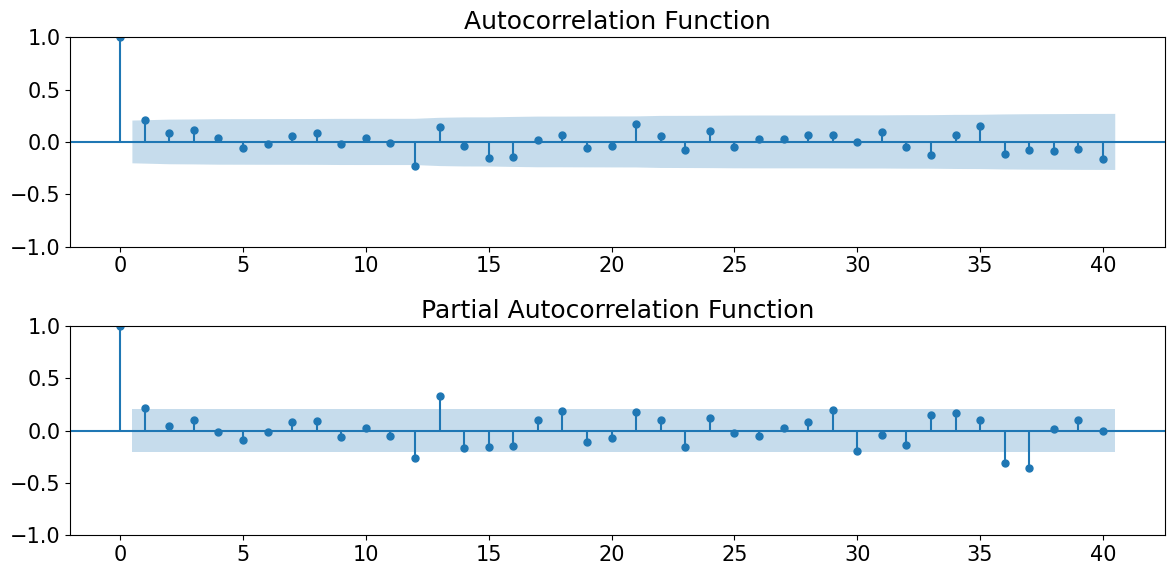

In [35]:
# Create a 2x1 subplot grid
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6))

# Plot Autocorrelation Function (ACF)
plot_acf(data['Seasonal_first_difference'].iloc[13:], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function')

# Plot Partial Autocorrelation Function (PACF)
plot_pacf(data['Seasonal_first_difference'].iloc[13:], lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

# Adjust layout for better readability
plt.tight_layout()

# Show the plots
plt.show()

### Decomposition

Decompose the time series data

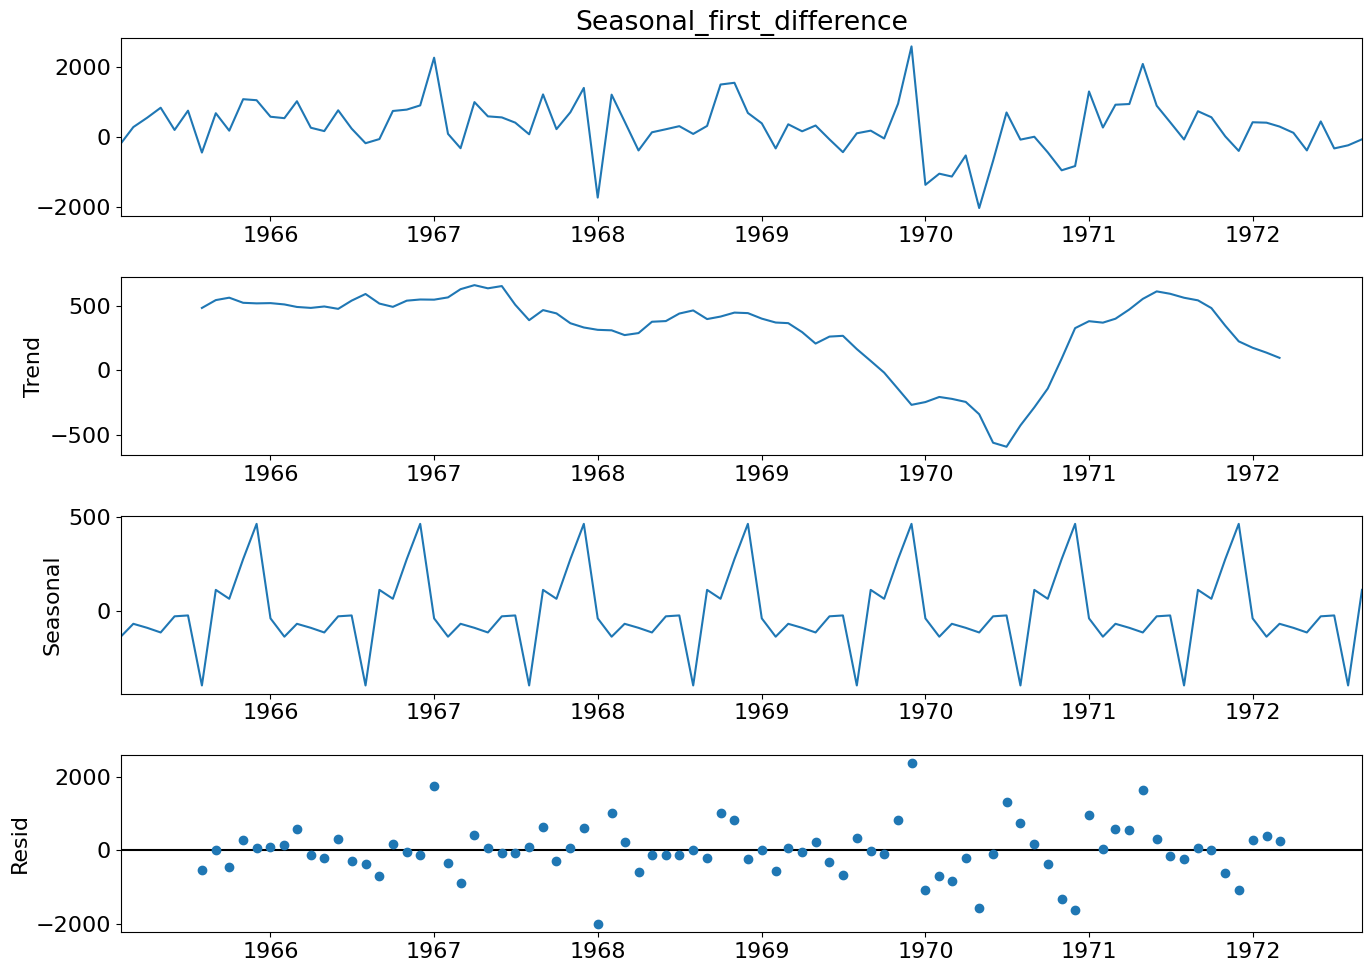

In [36]:
ts = data['Seasonal_first_difference'].iloc[13:]

plt.rc('figure',figsize=(14,10))
plt.rc('font',size=16)

result = seasonal_decompose(ts,model='additive')
fig = result.plot()

In above plot -- all the components are clearly interpretable.

**Points to ponder:**
1. ```There’s not any  significant spike in ACF.```
2. ```PACF is nearly sinusoidal```

```The differencing factor d should be kept at 1 since there’s a clear trend.```

```Taking p = 1, q = 1, d = 1```

* **p - Autoregressive Order** -- represents the numberof lag observations included in the model.
* **d - Integrated Order** -- represents the number of differences neede to make the time series stationary.
* **q - Moving Average Order** -- specifies the size of the moving avaerage window -- It represents the number of lag foreacst errors in the prediction equation.

## 6. Fitting ARIMA

* ARIMA model is ```a class of linear models``` that ```utilizes historical values to forecast``` future values. 
* ARIMA stands for ```Autoregressive Integrated Moving Average```, each of which technique contributes to the final forecast.

In [37]:
# Instantiate the model:

arima_model = ARIMA(data['Sales'], order=(12,1,1))

In [38]:
# Fit the model on training dataset:
arima_model_fit = arima_model.fit()

In [39]:
# Check the summary of the model:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                ARIMA(12, 1, 1)   Log Likelihood                -857.733
Date:                Sat, 31 Aug 2024   AIC                           1743.467
Time:                        10:22:57   BIC                           1780.488
Sample:                    01-01-1964   HQIC                          1758.465
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0607      0.089      0.681      0.496      -0.114       0.235
ar.L2         -0.1293      0.083     -1.553      0.120      -0.292       0.034
ar.L3          0.0011      0.078      0.014      0.988      -0.153       0.155
ar.L4         -0.1291      0.093     -1.389      0.165      -0.311       0.053
ar.L5          0.0015      0.089      0.017      0.987      -0.173       0.176
ar.L6         -0.1006      0.112     -0.902      0.367      -0.319       0.118
ar.L7          0.0172      0.098      0.177      0.860      -0.174       0.208
ar.L8         -0.1474      0.102     -1.439      0.150      -0.348       0.053
ar.L9          0.0210      0.106      0.198      0.843      -0.188       0.230
ar.L10        -0.1001      0.085     -1.174      0.241      -0.267       0.067
ar.L11         0.0185      0.077      0.240      0.810      -0.132       0.169
ar.L12         0.7974      0.074     10.707      0.000       0.651       0.943
ma.L1         -0.8155      0.130     -6.278      0.000      -1.070      -0.561
sigma2      5.681e+05   6.08e+04      9.337      0.000    4.49e+05    6.87e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               101.13
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.51
Prob(H) (two-sided):                  0.69   Kurtosis:                         7.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
# check the shape of the model
data.shape

(105, 3)

In [41]:
# forecast the model:
data['forecast'] = arima_model_fit.predict(start = 80, end = 104, dynamic = True)

<Axes: xlabel='Month'>

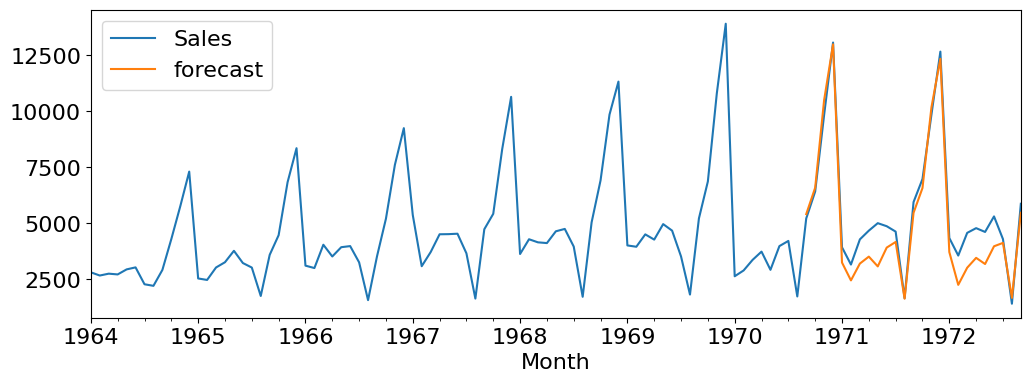

In [42]:
# compare the foracasted value by plotting actual values together:
data[['Sales', 'forecast']].plot(figsize=(12,4))

From above plot -- we can interprete that my model is unable to capture the seasonality accuractely.

```whenever we have seasonal data ARIMA is not suitable. ```
```We will use SARIMAX which is Seasonal ARIMA, it is an extension of ARIMA.```

## 7. Fitting SARIMAX

```(p,d,q), (P, D, Q, s)```

* **p - Autoregressive Order** -- represents the number of lag observations included in the model.
* **d - Integrated Order** -- represents the number of differences neede to make the time series stationary.
* **q - Moving Average Order** -- specifies the size of the moving avaerage window -- It represents the number of lag foreacst errors in the prediction equation.

* **P - Seasonal Autoregressive Order** -- similar to p -- but for the seasonal component -- represents the numberof lag observations at seasonal intervals in the autoregressive part of the model.
* **D - Seasonal Integrated Order** -- similar to d -- but for the seasonal component -- represents the number of differences needed to make the seasonal part of the time series stationary.
* **Q - seasonal Moving Average Order** -- similar to q -- but for the seasonal component -- specifies the size of the seasonal moving avaerage window.

* **s - Seasonal Periodicity** --defines the number of time steps in a seasonal cycle -- here data has a yearly seasonality -- "s" will be 12 for monthly data.

In [44]:
# import statsmodels.api as sm

In [45]:
# Initialize the SARIMA Model

sarima_model=sm.tsa.statespace.SARIMAX(data['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))

In [46]:
# Fitting the SARIMA model:

sarima_model_fit = sarima_model.fit()

In [47]:
# forecasting the sales avlue using SARIMAX model from index 90 to 104

data['sarima_forecast'] = sarima_model_fit.predict(start=90,end=104,dynamic=True)

<Axes: xlabel='Month'>

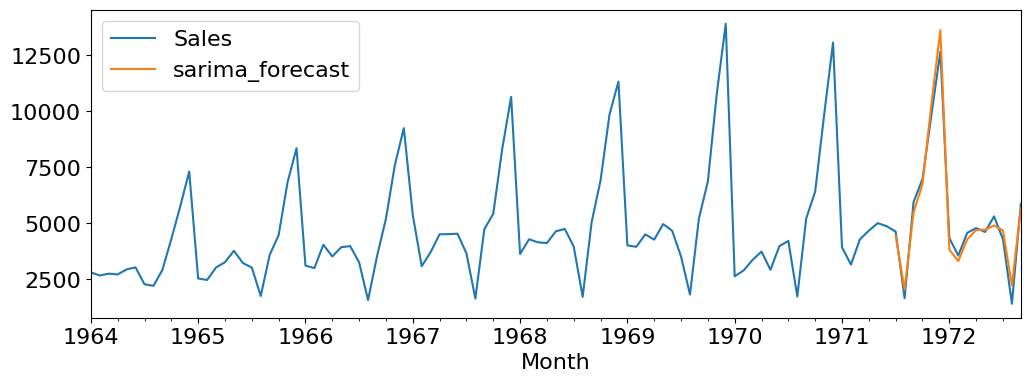

In [50]:
# compare the foracasted value by plotting actual values together:

data[['Sales', 'sarima_forecast']].plot(figsize=(12,4))

## 8. Prediction Outcomes:

Analyze the forecasting sales values for both the model -- ARIMA and SARIMAX

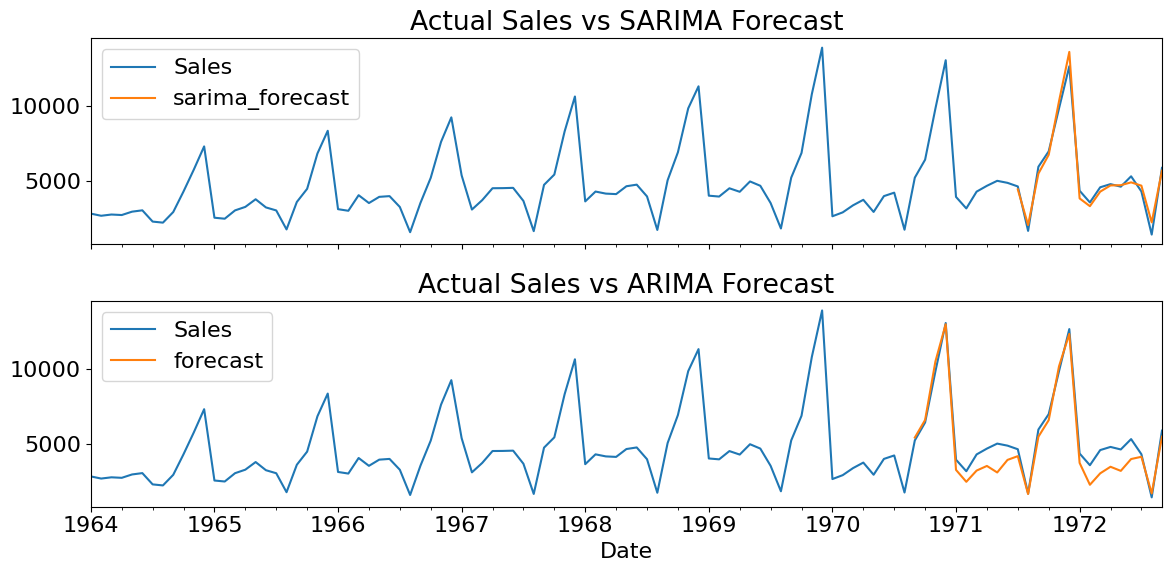

In [51]:
# Plotting in subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plotting the first subplot (Sales and sarima_forecast)
data[['Sales', 'sarima_forecast']].plot(ax=axs[0])
axs[0].set_title('Actual Sales vs SARIMA Forecast')

# Plotting the second subplot (Sales and forecast)
data[['Sales', 'forecast']].plot(ax=axs[1])
axs[1].set_title('Actual Sales vs ARIMA Forecast')

# Setting common x-axis label
plt.xlabel('Date')

# Adjusting layout
plt.tight_layout()

# Show the plots
plt.show()

```FROM above it is clear that SARIMAX model is perform batter -- in the sace of "seasonality" presentin the time series data.```

## 9. Making Predictions on Future Data with SARIMAX:

In [ ]:
# Import DateOffset:
from pandas.tseries.offsets import DateOffset

# appending future dates in dataframe index:  -- (Let's say for 24 months)
future_dates = [data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [ ]:
# Save as a new dataframe:

future_datest_df = pd.DataFrame(index = future_dates[1:], columns = data.columns)

In [ ]:
# see last few rows:
future_datest_df.tail(6)

,Sales,Sales_first_difference,Seasonal_first_difference,forecast,sarima_forecast
1974-03-01,NaN,NaN,NaN,NaN,NaN
1974-04-01,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Chcek shape of newly created dataframe:
future_datest_df.shape

(23, 5)

In [ ]:
# Concatenating both the dataframes:

future_df = pd.concat([data, future_datest_df])

In [ ]:
# Forecasting the Sales values based on above SARIMAX Model:

future_df['sarima_forecast'] = sarima_model_fit.predict(start = 104, end = 120, dynamic= True)  


<Axes: >

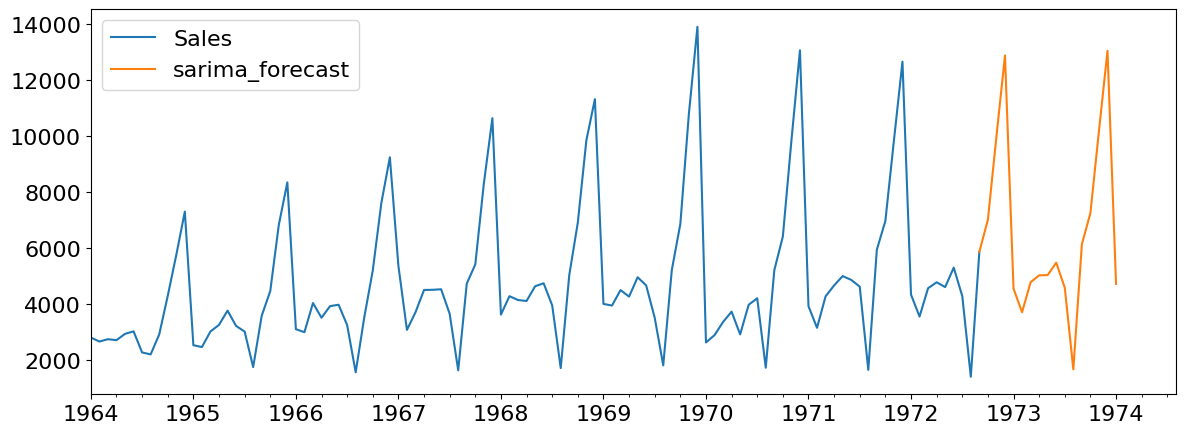

In [ ]:
# Plotting the final predicted Sales value for next 2-years:

future_df[['Sales', 'sarima_forecast']].plot(figsize=(14, 5)) 

## 10. Pros and Cons of ARIMA & SARIMA

### Pros of ARIMA & SARIMA

- **Easy to understand and interpret:** 
    The one thing that your fellow teammates and colleagues would appreciate is the simplicity and interpretability of the models. Focusing on both of these things while also maintaining the quality of the results will help with presentations with the stakeholders.

- **Limited variables:** 
    There are fewer hyperparameters so the config file will be easily maintainable if the model goes into production.

### Cons of ARIMA & SARIMA

**Exponential time complexity:** 
    When the value of p and q increases there are equally more coefficients to fit hence increasing the time complexity manifold if p and q are high. This makes both of these algorithms hard to put into production and makes Data Scientists look into Prophet and other algorithms. Then again, it depends on the complexity of the dataset too.


**Complex data:** 
    There can be a possibility where your data is too complex and there is no optimal solution for p and q. Although highly unlikely that ARIMA and SARIMA would fail but if this occurs then unfortunately you may have to look elsewhere.


**Amount of data needed:** 
    Both the algorithms require considerable data to work on, especially if the data is seasonal. For example, using three years of historical demand is likely not to be enough (Short Life-Cycle Products) for a good forecast.